# Data Preprocessing
## Import Packages and Set Up Environment
### Import Core Packages|

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import sys
import os
from pathlib import Path
import platform
import shutil

### Get Current Operating System and Set Paths Dependent on Working OS

In [2]:
# Get current OS and set paths dependent on working OS.
cur_system = platform.system()

# Get Data Directory
basepath = Path(r'E:\Data\PCDisruption\Strawberry\Stb_2024-10-31_Sonoma')
cur_folder = Path(basepath).name
session_name = re.sub(r'_\d{4}-\d{2}-\d{2}_', '_', cur_folder)

print('Basepath:', basepath)
print('Working Directory:', cur_folder)
print('Session Name:', session_name)

Basepath: E:\Data\PCDisruption\Strawberry\Stb_2024-10-31_Sonoma
Working Directory: Stb_2024-10-31_Sonoma
Session Name: Stb_Sonoma


In [3]:
# Set up environment for windows
if cur_system == "Windows":
    sys.path.extend(['E:\\Code\\Repositories\\NeuroPy'])  # NeuroPy Path
    save_dir = Path('E:\\Analyses\\Preprocessing')
elif cur_system == "Linux":
    save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing')
    
    # Old Code, just in case new code breaks
    #basepath = os.getcwd()

    #save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing')
    #plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing/Plots')
# Set Session name as folders for notebook outputs
save_dir = Path(save_dir / cur_folder)
plot_dir = Path(save_dir / 'Plots')

save_dir.mkdir(parents=True, exist_ok=True)
plot_dir.mkdir(parents=True, exist_ok=True)

print('Save Directory:', save_dir)
print('Plot Directory:', plot_dir)

Save Directory: E:\Analyses\Preprocessing\Stb_2024-10-31_Sonoma
Plot Directory: E:\Analyses\Preprocessing\Stb_2024-10-31_Sonoma\Plots


### Import NeuroPy Packages

In [4]:
# Import NeuroPy Packages
from neuropy import core
from neuropy.core import Epoch
from neuropy.core.session import ProcessData

from neuropy.analyses.artifact import detect_artifact_epochs

from neuropy.plotting.signals import plot_signal_w_epochs

from neuropy.io.openephysio import *
from neuropy.io import SpykingCircusIO

from neuropy.io.neuroscopeio import NeuroscopeIO

### Import Session Data

In [5]:
session_name = re.sub(r'_\d{4}-\d{2}-\d{2}_', '_', cur_folder)
sess = ProcessData(basepath)
print(sess.recinfo)
print(sess.eegfile)

filename: E:\Data\PCDisruption\Strawberry\Stb_2024-10-31_Sonoma\Stb_2024-10-31_Sonoma.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 4050.99 seconds 
duration: 1.13 hours 



## Preprocess Ephys Data
- Identify Artifacts
    - Disconnects
    - Filtering
- Send events files to check in Neuroscope
- Write `dead_times.txt` file for spyking-circus and `artifacts.npy` files
### Identify Disconnects and Motion Artifacts

Buffer of 0.25 added before/after each epoch
E:\Data\PCDisruption\Strawberry\Stb_2024-10-31_Sonoma\Stb_2024-10-31_Sonoma.art_epochs.npy saved
Artifact File: E:\Data\PCDisruption\Strawberry\Stb_2024-10-31_Sonoma\Stb_Sonoma.evt.art
Total artifact time = 242.8 seconds
Automatically detected artifact epochs:
        start       stop label  duration
0     69.5596    70.1076          0.5480
1    155.6012   158.9116          3.3104
2    218.7404   227.5012          8.7608
3    236.7220   240.1260          3.4040
4    251.1316   251.7220          0.5904
..        ...        ...   ...       ...
63  2547.3588  2548.9780          1.6192
64  3211.9948  3212.5612          0.5664
65  3254.0788  3256.1972          2.1184
66  3766.4804  3767.0348          0.5544
67  3888.6684  3889.2204          0.5520

[68 rows x 4 columns]


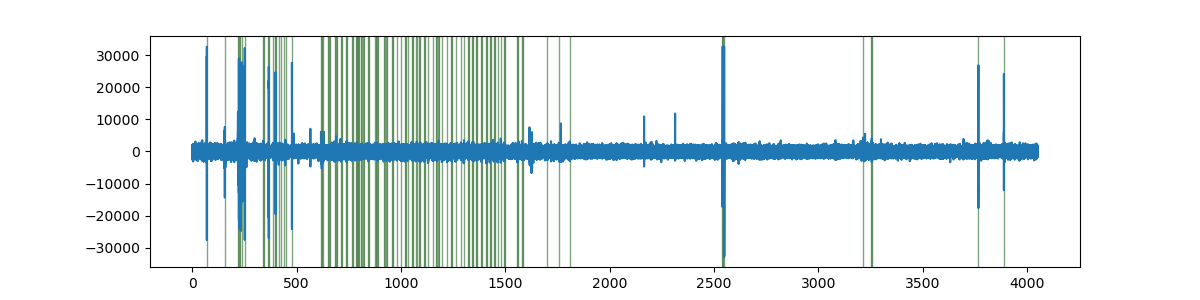

In [9]:
%matplotlib widget

# Parameters
buffer_add = 0.25    # Add buffer before and after detected artifact epochs, None = don't add any
art_thresh = 6     # Artifact detection threshold
art_edge_cutoff = 2  # Edge cutoff value
art_merge = 6        # Merges epochs that are too close to each other

# Plot Parameters
chan_plot = 8

# Get signal object
signal = sess.eegfile.get_signal()

# Find artifact epochs
art_epochs = detect_artifact_epochs(signal, thresh=art_thresh, edge_cutoff=art_edge_cutoff, merge=art_merge)

# Add in a buffer to prevent erroneous detetion of start/stop of artifact as SWRs.
if buffer_add is not None:
    art_epochs.add_epoch_buffer(buffer_add)

# Plot automatically detected epochs to see how they look
art_fig = plot_signal_w_epochs(signal, chan_plot, art_epochs)

# Save evt.art file to visualize in Neuroscope
sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
ns_art_file = basepath / f"{cur_folder}.evt.art"
print('Artifact File:', ns_art_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
print('Automatically detected artifact epochs:')
print(art_epochs.to_dataframe())

### Check Events in Neuroscope
- Load evt.art file in Neuroscope and check if it aligns with artifacts in the signal.
- Check if there are any other artifact epochs that were missed by the automatic detection

E:\Data\PCDisruption\Strawberry\Stb_2024-10-31_Sonoma\Stb_2024-10-31_Sonoma.art_epochs.npy saved
Total artifact time = 31.5 seconds
Automatically detected artifact epochs:
        start       stop label  duration
0     69.5596    70.1076          0.5480
1    155.6012   158.9116          3.3104
2    218.7404   227.5012          8.7608
3    236.7222   240.1262          3.4040
4    251.1316   251.7222          0.5906
5    366.3386   367.0348          0.6962
6    398.3576   398.5896          0.2320
7    477.2852   477.8372          0.5520
8    565.7392   565.9776          0.2384
9    616.4052   620.6382          4.2330
10   628.1188   628.7244          0.6056
11  1618.2786  1618.6010          0.3224
12  1766.3618  1766.6786          0.3168
13  2164.4720  2165.0328          0.5608
14  2313.3658  2313.7546          0.3888
15  2540.4644  2541.8382          1.3738
16  2547.3588  2548.9782          1.6194
17  3211.9948  3212.5612          0.5664
18  3254.0788  3256.1972          2.1184
19  3766

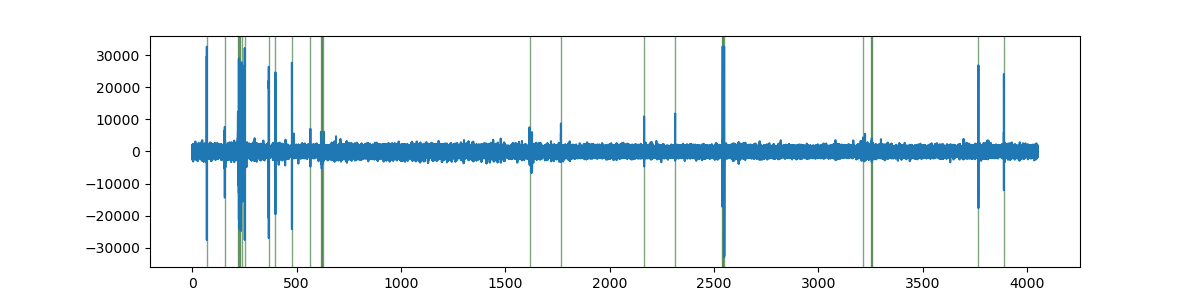

In [13]:
ns_art_file = basepath / f"{cur_folder}.evt.art"

art_epochs = sess.recinfo.event_to_epochs(ns_art_file)
art_epochs.save(art_epochs_file)
print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
print('Automatically detected artifact epochs:')
print(art_epochs.to_dataframe())

# Plot artifact onto an example channel
chan_plot = 8 # Select a good channel
art_fig = plot_signal_w_epochs(signal, chan_plot, art_epochs)
art_fig_name = f'{session_name}_Artifacts_Channel{chan_plot}.png' 
plt.savefig(plot_dir / art_fig_name, dpi=300, bbox_inches='tight')  # Save with full path

### Identify Stimulation Epochs
- Stimulation will have artifacts that are highly stereotyped

In [27]:
SR = sess.recinfo.dat_sampling_rate

# Get sample numbers for TTL Events
ttl_events = load_all_ttl_events(sess.basepath)

stim_on_events = ttl_events.loc[ttl_events["channel_states"] == 1, "sample_number"]
stim_off_events = ttl_events.loc[ttl_events["channel_states"] == -1, "sample_number"]
stim_art_events = ttl_events.loc[ttl_events["channel_states"].abs() == 1, "sample_number"]

stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")

stim_epochs = Epoch(pd.DataFrame({
    "start": stim_on_events.reset_index(drop=True) / SR, 
    "stop": stim_off_events.reset_index(drop=True) / SR, 
    "label": ""
    }))

stim_epochs_df = stim_epochs.to_dataframe()
stim_epochs_df['time_between'] = stim_epochs_df['start'] - stim_epochs_df['stop'].shift(1)
stim_epochs_df = stim_epochs_df.drop(0)

# Rudimentary Labeling
stim_epochs = Epoch(stim_epochs_df)
sess.recinfo.write_epochs(epochs=stim_epochs, ext='stm')
stim_epochs.save(stim_epochs_file)

pd.set_option('display.max_rows', None)
print(stim_epochs_df)

E:\Data\PCDisruption\Strawberry\Stb_2024-10-31_Sonoma\Stb_2024-10-31_Sonoma.stim_epochs.npy saved
            start         stop label  duration  time_between
1      386.632333   386.682333        0.050000      9.404233
2      386.737767   386.787767        0.050000      0.055433
3      386.830033   386.880033        0.050000      0.042267
4      386.939700   386.989667        0.049967      0.059667
5      387.032333   387.082333        0.050000      0.042667
6      387.141700   387.191700        0.050000      0.059367
7      387.235967   387.285933        0.049967      0.044267
8      387.330567   387.380567        0.050000      0.044633
9      387.441233   387.491233        0.050000      0.060667
10     387.535800   387.585800        0.050000      0.044567
11     390.640767   390.657233        0.016467      3.054967
12     390.657267   390.707267        0.050000      0.000033
13     390.762467   390.812433        0.049967      0.055200
14     390.870367   390.920367        0.050000  

#### Identify Stimulation Artifacts
Stimulation Artifact can currently be classified in several ways
- TTLs: Timestamps of the stim means we create a buffer around the TTL to determine the artifact.

            start         stop       dur  label
1      386.632333   386.687333  0.055000      0
2      386.737767   386.792767  0.055000      0
3      386.830033   386.885033  0.055000      0
4      386.939700   386.994667  0.054967      0
5      387.032333   387.087333  0.055000      0
6      387.141700   387.196700  0.055000      0
7      387.235967   387.290933  0.054967      0
8      387.330567   387.385567  0.055000      0
9      387.441233   387.496233  0.055000      0
10     387.535800   387.590800  0.055000      0
11     390.640767   390.662233  0.021467      0
12     390.657267   390.712267  0.055000      0
13     390.762467   390.817433  0.054967      0
14     390.870367   390.925367  0.055000      0
15     390.964433   391.019433  0.055000      0
16     391.059633   391.114633  0.055000      0
17     391.169433   391.224433  0.055000      0
18     391.262833   391.317800  0.054967      0
19     391.357700   391.412700  0.055000      0
20     391.466633   391.521633  0.055000

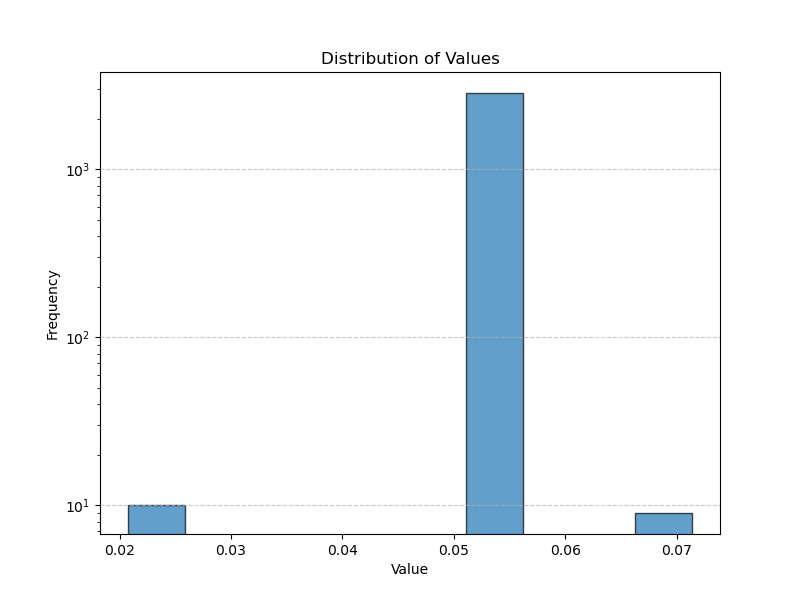

In [28]:
# Set buffer time to create an envelope for stim artifact cleaning
buffer = 0.005
stim_art_epochs_file = sess.filePrefix.with_suffix(".stim_art_epochs.npy")

stim_art_epochs_df = pd.DataFrame({
    'start': stim_epochs_df['start'],
    'stop': stim_epochs_df['stop'] + buffer,
    'dur': (stim_epochs_df['stop'] + buffer) - stim_epochs_df['start'],
    'label': 0
})

print(stim_art_epochs_df)

plt.figure(figsize=(8,6))
plt.hist(stim_art_epochs_df['dur'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of Values')
plt.yscale('log')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [47]:
conditions = [
    (stim_art_epochs_df['dur'] < 0.03),
    (stim_art_epochs_df['dur'] >= 0.05) & (stim_art_epochs_df['dur'] <= 0.06),
    (stim_art_epochs_df['dur'] > 0.065)
]
choices = [0, 1, 2]
stim_art_epochs_df['label'] = pd.cut(stim_art_epochs_df['dur'], bins=[-float('inf'), 0.03, 0.06, float('inf')], labels=[0, 1, 2])

stim_window_df = pd.DataFrame({
    'label': choices,
    'dur': [stim_art_epochs_df[stim_art_epochs_df['label'] == label]['dur'].mean() for label in unique_labels]
})


stim_art_epochs = Epoch(stim_art_epochs_df)
sess.recinfo.write_epochs(epochs=stim_art_epochs, ext='sta')
stim_art_epochs.save(stim_art_epochs_file)

   label       dur
0      0  0.021707
1      1  0.054994
2      2  0.070607
E:\Data\PCDisruption\Strawberry\Stb_2024-10-31_Sonoma\Stb_2024-10-31_Sonoma.stim_art_epochs.npy saved


In [54]:
# Set buffer time to create an envelope for stim artifact cleaning
buffer = 0.005

stim_art_epochs_file = sess.filePrefix.with_suffix(".stim_art_epochs.npy")

start_adjusted = pd.DataFrame({
    'start': stim_epochs_df['start'] - buffer,
    'stop': stim_epochs_df['start'] + buffer,
    'label': 0
})

stop_adjusted = pd.DataFrame({
    'start': stim_epochs_df['stop'] - buffer,
    'stop': stim_epochs_df['stop'] + buffer,
    'label': 1
})

stim_art_epochs_df = pd.concat([start_adjusted, stop_adjusted]).sort_values(by='start').reset_index(drop=True)
stim_art_epochs = Epoch(stim_art_epochs_df)
print(stim_art_epochs_df)
sess.recinfo.write_epochs(epochs=stim_art_epochs, ext='sta')
stim_art_epochs.save(stim_art_epochs_file)

            start         stop  label
0      460.354333   460.364333      0
1      460.404333   460.414333      1
2      503.162633   503.172633      0
3      503.212633   503.222633      1
4      503.250700   503.260700      0
...           ...          ...    ...
2919  1904.661667  1904.671667      1
2920  1904.712800  1904.722800      0
2921  1904.762800  1904.772800      1
2922  1904.813400  1904.823400      0
2923  1904.863400  1904.873400      1

[2924 rows x 3 columns]
D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton\Stb_Bridgehampton.stim_art_epochs.npy saved


#### Write Stim Artifact to a Trigger Detection File

In [55]:
def create_stim_times(row):
    prefix = int(row['label'])
    start_ms = row['start'] * 1000  # Convert start time to milliseconds
    return f"{prefix} {start_ms:.6f}"

# Create spyk-circ directory
spyk_circ = basepath / 'spyk-circ'
os.makedirs(spyk_circ, exist_ok=True)
stim_times = stim_art_epochs_df.apply(create_stim_times, axis=1)
stim_times_filepath = spyk_circ / 'stim_times.txt'
output.to_csv(stim_times_filepath, index=False, header=False)

# Create Stim Windows Text File
stim_windows_filepath = spyk_circ / 'stim_windows.txt'
with open(stim_windows_filepath, "w") as file:
    file.write("// Estimated duration of artifacts\n")
    for index, row in stim_window_df.iterrows():
        file.write(f"// Stim {row['label']} lasts {row['dur']:.6f} ms\n")
    for index, row in stim_window_df.iterrows():
        file.write(f"{int(row['label'])} {row['dur']:.6f} # Opto \n")


In [48]:
print(stim_window_df)

   label       dur
0      0  0.021707
1      1  0.054994
2      2  0.070607


### Write to Spyking-Circus `dead_times.txt` File
- Text file containing 2 columns, start and stop of artifact epochs that should be ignored by spike sorting algorithm.

In [57]:
sess.filePrefix.with_suffix(".art_epochs.npy")
SpykingCircusIO.write_epochs(spyk_circ / 'dead_times.txt', art_epochs)

dead_times.txt created


In [68]:
import shutil

# Copy .dat file to spyk-circ
source = basepath / (cur_folder + ".dat")
dest = basepath / "spyk-circ" / (cur_folder + ".dat")
shutil.copy(source, dest)
print(f"File copied successfully from {source} to {dest}")


File copied successfully from E:\Data\PCDisruption\Strawberry\Stb_2024-10-31_Sonoma\Stb_2024-10-31_Sonoma.dat to E:\Data\PCDisruption\Strawberry\Stb_2024-10-31_Sonoma\spyk-circ\Stb_2024-10-31_Sonoma.dat


In [69]:
from datetime import datetime
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

log_path = basepath / f"{session_name}_Processing_Log.txt"
log_path.parent.mkdir(parents=True, exist_ok=True)
with open(log_path, 'w') as file:
    file.write(f"Session name: {session_name}\n")
    file.write(f"Datetime: {current_datetime}\n")
    file.write(f"Working OS: {cur_system}\n")
    file.write(f"Basepath: {basepath}\n")
    file.write(f"Working Directory: {cur_folder}\n")
    file.write(f"Session Name: {session_name}\n")
    file.write(f"Save Directory: {save_dir}\n")
    file.write(f"Plot Directory: {plot_dir}\n\n")

    file.write("Artifact Detection Parameters:\n")
    file.write(f"Buffer: {buffer_add}\n")
    file.write(f"Artifact Threshold: {art_thresh}\n")
    file.write(f"Artifact Edge Cutoff: {art_edge_cutoff}\n")
    file.write(f"Artifact Merge Distance: {art_merge}\n")
    file.write(f"Stimulation Artifact Buffer: {buffer}\n\n")